# Geospatial analysis with Python

Valencia - [PyConES 2015](http://2015.es.pycon.org/en/) - 2015/11/22

- Pedro-Juan Ferrer · [@vehrka](http://twitter.com/vehrka)
- Jorge Sanz - [@xurxosanz](http://twitter.com/xurxosanz)
- Geoinquietos Valencia - [@geoinquietosvlc](http://twitter.com/geoinquietosvlc)

Slides and repo

- http://bit.ly/pycones2015-geo
- https://github.com/geoinquietosvlc/2015.es.pycon



# 1. Introduction to Spatial Data

the *Geographic Data problem*

or

**Spacial is Special**

## GEO Problem?

![ORLY](img/orly.jpg)

You have to deal with data that has special rules.

Rules based on a reality not told in schools

## Earth is not a sphere

![Typical representation of the Earth as sphere](img/sphere.jpg)

## Earth is more like a potato


![Image of a free range potato](img/potato.jpg)

## A potato

Believe me, I know what I'm talking about

![Image of a geoid](img/geoide.jpg)

## Geoids are physical

Although its the true shape of the Earth, we can't measure over it.

![No measure is possible](img/nomeasure.jpg)

## We need mathematics

An **Ellipsoid**

![Image of an ellipsoid](img/ellipsoid.jpg)

## Ellipsoid vs Geoid

On average, they are quite similar

![Ellipsoid compared to geoid](img/ellip_vs_geoid.jpg)

## Datum is the name of the game 

The Ellipsoid and a couple more of things is what we call:

### the **DATUM**

(And there are not one but several Datums, understanding this takes several courses of Geodesy, trust me on this)


## Earth is not a sphere

*Remember*

> The **GEO** information lays over something *mathematical* that has its own rules.

> **THE DATUM**

## Maps are flat

![Image of a flat screen with a map](img/flat_screen.jpg)

## Making things flat

But you can't turn **flat** something spherical

(without breaking it)

![Image of a map on an orange skin](img/orange_map.jpg)

## Breaking Flat

You have to choose what you want to *break*:

* **Areas**
* **Angles**
* **Distances**

In the best case you can choose two of the three.

(I'm skipping several courses on Cartography with this slide, trust me on this)

## Choose your weapon!: The Projection

Cartographers have tricks for breaking things **mathematically**

[![xkcd on map projections](img/map_projections.jpg)](https://xkcd.com/977/)

## Maps are flat

*Remember*

> The **GEO** information uses a *mathematical* trick to make things **flat** orderly.

> **THE PROJECTION**

## SRS and CRS

Toghether a *DATUM* and a *PROJECTION* make a **CRS**

The most famous catalog of *CRS* is **EPSG**

* EPSG:4326
* EPSG:3857 or EPSG:900913
* EPSG:4258
* EPSG:25830, EPSG:25831

## Geo data types

These one are easy

Because you are more used to it

## Raster and Vector data

![Raster data model](img/raster_data.jpg)

![Vector data model](img/vector_data.jpg)

## Data model

How many geometry types do you know?

... Point, Line, Surface ...

## Well, it's complicated...

OGC **Simple** Feature Access

![OGC Simple Feature Specification](img/ogc_sfs.jpg)

## lon/lat vs lat/lon

There's a little bit of fuss

In theory it should be lon/lat (x,y)

But we are used to lat/lon

**Always check things ... twice**

## Recap

* Know your **Datum**
* Know your **Projection**
* Know your **Data Type**
* Know your **Model**

**KNOW YOUR (geo) DATA!!!**

# 2. Writing and reading data

## Fiona
- http://toblerity.org/fiona/
- Modern pythonic wrapper around [OGR](http://www.gdal.org/index.html)
- Simple and dependable
- Integrates with [pyproj](http://pypi.python.org/pypi/pyproj/), [Rtree](http://pypi.python.org/pypi/Rtree/) and [Shapely](http://pypi.python.org/pypi/Shapely/)

In [1]:
from fiona.collection import supported_drivers
for frmt in sorted(supported_drivers):
    print("{:20}{}".format(frmt,supported_drivers[frmt]))

ARCGEN              r
AeronavFAA          r
BNA                 raw
DGN                 raw
DXF                 raw
ESRI Shapefile      raw
FileGDB             raw
GMT                 raw
GPKG                rw
GPSTrackMaker       raw
GPX                 raw
GeoJSON             rw
Idrisi              r
MapInfo File        raw
OpenFileGDB         r
PCIDSK              r
PDS                 r
SEGY                r
SUA                 r


## Exercise

1. Import a CSV and write into a geospatial file
2. Read that file and explore contents
3. Report

## Writing a shapefile from a CSV

1. reading a CSV from CartoDB [SQL API](http://docs.cartodb.com/cartodb-platform/sql-api/) (querying [this table](https://team.cartodb.com/u/jsanz/tables/twitter_pycones_pycones2015_pycones15/public))
2. creating a schema
3. creating features and writing them

![](img/logo-cartodb.png)
```sql
select 
    ST_X(the_geom) as lon, 
    ST_Y(the_geom) as lat, 
    cartodb_id, actor_preferredusername, body, postedtime 
from 
    jsanz.twitter_pycones_pycones2015_pycones15
```

In [2]:
import requests
url = 'https://jsanz.cartodb.com:443/api/v2/sql?q=select ST_X(the_geom) as lon, ST_Y(the_geom) as lat, cartodb_id, actor_preferredusername, body, postedtime from jsanz.twitter_pycones_pycones2015_pycones15&format=csv'
csv_file = '/tmp/tweets.csv'

with open(csv_file,'w') as csvfile:
    req = requests.get(url)
    csvfile.write(req.text)

In [3]:
target = '/tmp/tweets.shp'
epsg = 4258 # http://epsg.io/4258
driver = "ESRI Shapefile"
schema = {
        "geometry": "Point",
        "properties": {
            ("cartodb_id", "int"),
            ("lon","float"),
            ("lat","float"),
            ("author","str"),
            ("body","str"),
            ("postedtime","str")
        }
}

In [4]:
import fiona, csv
from fiona.crs import from_epsg

In [5]:
output = fiona.open(target, "w", driver=driver, 
                    crs=from_epsg(epsg), schema=schema)
with open(csv_file,'r') as csvfile:
    csvreader = csv.reader(csvfile,delimiter=',',quotechar='"')
    next(csvreader) #skip the header
    for line in csvreader:
        try:
            x = float(line[0])
            y = float(line[1])
            
            feature = {
                    "geometry" : {
                            "coordinates" : (x, y), "type" : "Point"
                    },
                    "properties" : {
                            "cartodb_id" : int(line[2]),
                            "lon" : x,
                            "lat" : y,
                            "author" : line[3],
                            "body" : line[4],
                            "postedtime" : line[5]
                    }
            }
            output.write(feature)
        except ValueError:
            pass
    try:
        output.close()
    except RuntimeError:
        pass

## Reading and exploring data

1. Open a Shapefile
2. Getting information of the resource
3. Looping over features

In [6]:
source = fiona.open(target, 'r')

In [7]:
"  ".join([atr for atr in dir(source) if atr[0] != '_'])

'bounds  close  closed  crs  crs_wkt  driver  enabled_drivers  encoding  env  filter  flush  guard_driver_mode  items  iterator  keys  meta  mode  name  next  path  schema  session  validate_record  validate_record_geometry  values  write  writerecords'

In [8]:
print("{} tweets\r\n".format(len(source)))
print("bounds: {}\r\n".format(source.bounds))
print("CRS: {}".format(source.crs))

1031 tweets

bounds: (-123.26204, -43.24895, 151.77647, 55.95206)

CRS: {'no_defs': True, 'proj': 'longlat', 'ellps': 'GRS80'}


In [9]:
print("{:3} - {:15} - {:^15}\r\n{:*^45}".format("ID","Author","Coords",""))
for f in source[:10]:
    print("{:3} - {:15} - {}"
          .format(f['properties']['cartodb_id'],
                  f['properties']['author'], 
                  f['geometry']['coordinates']))

ID  - Author          -     Coords     
*********************************************
187 - rmajadas        - (-3.69063, 40.42526)
 39 - CValdeMontes    - (2.15899, 41.38879)
249 - python_granada  - (-3.60667, 37.18817)
247 - sdelquin        - (-16.25462, 28.46824)
105 - ipedrazas       - (-0.12574, 51.50853)
206 - rafbermudez     - (-3.69063, 40.42526)
192 - rafbermudez     - (-3.69063, 40.42526)
  9 - seattle113      - (-4.52406, 42.00955)
 35 - d1eg0_garc1a    - (2.15899, 41.38879)
 99 - ipedrazas       - (-0.12574, 51.50853)


## Displaying the imported data

There are some libraries to plot geographical data

- [Descartes](https://pypi.python.org/pypi/descartes/)
- [Cartopy](http://scitools.org.uk/cartopy/)
- [Folium](https://folium.readthedocs.org/)

In [10]:
import folium
basemap = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'
map = folium.Map(location=[39.5,-2.5], 
                 zoom_start=6, width=960, height=600,
                 tiles=basemap, attr='OpenStreetMap and Twitter')

In [13]:
for f in source:
    x,y = f['geometry']['coordinates']
    map.simple_marker(
        [y,x], #lat/lon!!!
        popup=f['properties']['body'])

In [14]:
map

![](http://media.giphy.com/media/8RxCFgu88jUbe/giphy.gif)

# 3. Processing

## Shapely

- http://toblerity.org/shapely/
- 2D geometry processing
- Pythonic wrapper for [GEOS](https://trac.osgeo.org/geos/)
- Agnostic of coordinate systems or data formats

![](http://farm3.staticflickr.com/2738/4511827859_b5822043b7_o_d.png)

## Exercise

1. Define a point at PyConES venue
2. Create a buffer of a radius of 100 km around it
3. Find tweets inside that buffer
4. Report

## Create a point

We can use the [Well Known Text](https://en.wikipedia.org/wiki/Well-known_text?oldformat=true) format to define a Shapely geometry.

![](img/wkt.png)

In [15]:
from shapely.wkt import loads
pycones = loads("POINT (-0.346713 39.482767)")

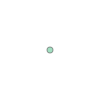

In [16]:
pycones

![](http://i.imgur.com/fUyfn8a.gif)

In [17]:
"  ".join([ atr for atr in dir(pycones) if atr[0] != '_'])

'almost_equals  area  array_interface  array_interface_base  boundary  bounds  buffer  centroid  contains  convex_hull  coords  covers  crosses  ctypes  difference  disjoint  distance  empty  envelope  equals  equals_exact  geom_type  geometryType  has_z  impl  interpolate  intersection  intersects  is_closed  is_empty  is_ring  is_simple  is_valid  length  overlaps  project  relate  relate_pattern  representative_point  simplify  svg  symmetric_difference  to_wkb  to_wkt  touches  type  union  within  wkb  wkb_hex  wkt  x  xy  y  z'

In [18]:
print('pycones {}\r\n'.format('is valid' 
                              if pycones.is_valid  else 'is not valid'))
print('WKT: {}\r\n'.format(pycones.wkt))
print('SVG: {}\r\n'.format(pycones.svg()))

pycones is valid

WKT: POINT (-0.346713 39.482767)

SVG: <circle cx="-0.346713" cy="39.482767" r="3.0" stroke="#555555" stroke-width="1.0" fill="#66cc99" opacity="0.6" />



## Create a buffer

- We cannot create a buffer of 100km around a geodetic point
- We need to compute the buffer on a projected CRS

  1. Project the point to UTM coordinates
  2. Compute the buffer
  3. Project the buffer to lat/lon coordinates

Shapely provides a method to allow using [pyproj](http://jswhit.github.io/pyproj/) with any geometry

In [19]:
import pyproj
from functools import partial

In [20]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4258'),
    pyproj.Proj(init='epsg:25830')
)
project_inv = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:25830'),
    pyproj.Proj(init='epsg:4326')
)

In [21]:
import shapely.ops
pycones_25830 = shapely.ops.transform(project,pycones)
print(pycones_25830)

POINT (728199.1076832865 4373712.985082146)


Once projected we are ready to define a Shapely Point object, compute the buffer and project it back to lon/lat coordinates

In [22]:
from shapely.geometry import Point

In [23]:
p = Point(pycones_25830)
pycones_buffer_25830 = p.buffer(100000)
pycones_buffer = shapely.ops.transform(project_inv,pycones_buffer_25830)

In [24]:
pycones_buffer.bounds

(-1.5089067784607482,
 38.582592551915646,
 0.8139462109021063,
 40.38277685271952)

## Intersect tweets

All ready to read the Shapefile, check if every feature is intersected by the buffer and fill a list of tuples with the distance and the tweet.

In [25]:
import fiona
from shapely.geometry import shape

In [26]:
tweets = []
with fiona.open('/tmp/tweets.shp','r') as source:
    for f in source:
        geometry = shape(f['geometry'])
        if pycones_buffer.intersects(geometry):
            geometry_25830 = shapely.ops.transform(project,geometry)
            distance = geometry_25830.distance(pycones_25830)
            tweets.append((distance,f))
print("{} tweets at less than 100km".format(len(tweets)))

118 tweets at less than 100km


**WARNING**: We need to transform to projected coordinates to get a distance in meters!

Let's sort the results and print the closest 10 tweets to PyConES venue

In [27]:
tweets = sorted(tweets, key=lambda tweet: tweet[0])

In [28]:
print("{:17} - {:>10} - {:>4}\r\n{:*^37}".format("Author","Distance","ID",""))
for distance,tweet in tweets[:10]:
    print("{:17} - {:10.2f} - {:4}"
          .format(tweet['properties']['author'],
                  distance,tweet['properties']['cartodb_id']))

Author            -   Distance -   ID
*************************************
ch_doig           -      30.17 -  666
ch_doig           -      58.11 -  583
ch_doig           -      60.24 -  601
manuerux          -     379.37 -  718
luiyo             -     514.44 -  779
xurxosanz         -     514.44 -  780
vero4ka_ru        -     514.44 -  783
sdelquin          -     917.01 -  806
andres_sanchis    -    3009.98 -  209
OFNblog           -    3009.98 -  262


## Displaying results

Let's use again folium but rendering also the buffer and with different colour for tweets inside.

In [29]:
basemap = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'
map = folium.Map(location=[39.5,-2.5], 
                 zoom_start=6, width=960, height=600,
                 tiles=basemap, attr='OpenStreetMap and Twitter')
buffer_coords = [ [lat,lon] for lon,lat in pycones_buffer.boundary.coords]
map.line(locations= buffer_coords)
with fiona.open('/tmp/tweets.shp','r') as source:
    for f in source:
        geometry = shape(f['geometry'])
        color = 'red' if pycones_buffer.intersects(geometry) else 'blue'
        x,y = f['geometry']['coordinates']
        map.simple_marker([y,x], marker_color=color,
                          popup=f['properties']['body'])


In [30]:
map

![](http://www.topito.com/wp-content/uploads/2013/06/fete.gif)

# Other libraries

- [GeoPandas](http://geopandas.org/index.html)
- [PySAL](http://pysal.readthedocs.org/)

From major Open Source desktop GIS projects:

- [PyQGIS](http://docs.qgis.org/testing/en/docs/pyqgis_developer_cookbook/)
- [gvSIG Scripting](http://docs.gvsig.org/plone/projects/gvsig-desktop/docs/user/gvsig-desktop-2-0-scripting)
- [GRASS Scripting](http://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library)


# That's all folks!
## Thanks! Questions?

- Pedro-Juan Ferrer · [@vehrka](http://twitter.com/vehrka)
- Jorge Sanz - [@xurxosanz](http://twitter.com/xurxosanz)
- Geoinquietos Valencia - [@geoinquietosvlc](http://twitter.com/geoinquietosvlc)

Valencia - [PyConES 2015](http://2015.es.pycon.org/en/) - 2015/11/22